<a href="https://colab.research.google.com/github/ronen-halevy/ai-notebooks/blob/main/image-classification/Building_Tensorflow_Image_Input_Pipeline_Part_2_Using_Keras_Utils.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building Tensorflow Image Pipeline Part 2 - Using Keras Utils Module
---


## Introduction
---


The Input Data Pipeline is the preprocessing stage of the Neural Network. It operates in an **`ETL`** (**E**xtract, **T**ransform, **L**oad) pipelined process, as depicted in the figure which follows.


**`Input Pipeline`:**


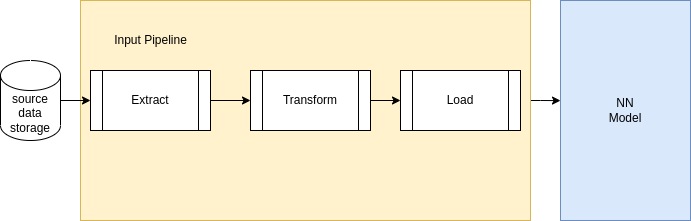

### **Input Pipeline Outlines**
---



The **Extract** block fetches data from input data source, which in case of Image Data Networks are most likely data files, and arranges them as dataset memory objects in local memory.

The **Transform** block, transformd the data to create an efficient input data set. Most of the transforms are regarded `Performance Transforms` as they format the data to achieve better compute performance.


The **Load** block transfers the data to the Network's input layer. 



### **Commonly used Data Transforms:**
---



- **Image Decoding** - decode either from jpeg or any coding format.
- **Data batching** - batches of data, be it image data or not, are required for an efficient parralelized process in general, and speciffically better exploits GPUs parralelism capabilities.
.
- **Resize** - Networks require uniform sized images only. Since source data images are mostly uniform in size, a `resize` operation is mandatory. Now, which is size to resize to? The answer is not always straight forward and definite. There are tradeoffs such as a tradeoff between details preservation vs compution and memory load. Anyway, we will set dimenssions such that after downsizing both height and width ramain integrer.



- **Rescale** - Rescales every value of an input by multiplying by scale and adding offset.



- **Caching** - avoid reloading at each epoch fitting cycle. Large datasets which do not fit in memory, should not be cached.

- **Shuffle** - which randomized the data loading sequence order.
- **Prefetch** - supports concurrent data prefetching and data processing.
- **Data Augmentation** - expands training dataset, increases the diversity of training set, by applying transformations, such as image rotation, flips, shifts.


### **About the series of posts**

This page is part of a series posts about **Building An Tensorflow Image Input Pipeline**.

Each post of this series presents one approach for the creation of an input image data pipeline, each uses a different set of APIs.

They differ in aspects such as level of integration (some are more integrated convinience api while others are less integrated but sometimes more flexible), and also differ in terms of efficiency and performance, (the `ImageGenerator` approach proves to be less performant)

Still, all approaches create a tensorflow dataset object which is an itegrated part of the Neural Netork Graph, along with the NN model, thus providing a smooth data integration throughout the process.

### Description of the Posts Contents

Each of the posts illustrates the creation of the input pipeline in the context of a data classification example, using various data sources: `rock-paper-scissors`, `flowers` and `horses or humans`


### List of the series posts:
---


The posts of this series are: 


- **Building Tensorflow Image Input Pipeline Part 1**: Using tf.data()

- [**Building Tensorflow Image Input Pipeline Part 2**: Using Keras Utils](https://colab.research.google.com/drive/1s3EdMO2uMWQMtqsPxIZOS-cvA4QqfMls#scrollTo=gpz8q177vSBj&uniqifier=2)

- **Building Tensorflow Image Input Pipeline Part 3**: Using ImageGenerator()
- **Building Tensorflow Image Input Pipeline Part 4**: Using TFDS()


Each of the posts illustrates the creation of the dataset within an image classification example. 

Let's go dive into the code!

###**Notes About this post approach- data pipeline Creation with Keras Utils**
---



The Keras Utils approach provides convinience methods for a compact and easy yet efficient data pipeline implelementation.



### **Horses Or Humans**
---


The input data used in this example is the `Horses Or Humans` dataset, listed in [TensorFlow Datasets catalog](https://www.tensorflow.org/datasets/catalog/overview). The dataset was produced by [Lawrance Moroney](https://laurencemoroney.com/datasets.html), million thanks for him on that.

## 1. Import Packages
---


In [173]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
import random

## 2. Download the data
---

- Download the dataset to local platform. 

- Data is packed in a .zip file. 

- When `extract=True` packed data is extracted



`####**Dowload Train Data files**

In [174]:
import pathlib
dataset_name = 'hoh'
dataset_url = 'https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip'
dataset_file = tf.keras.utils.get_file(origin=dataset_url, fname=dataset_name+'.zip', extract=True)

####**Print locally stored file path:**


In [175]:
print(dataset_file)

/root/.keras/datasets/hoh.zip


In [195]:
!ls /root/.keras/datasets

hoh.zip  horses  humans


####**Describe Downloaded File Tree**
Having set the `get_file()` with `extract=True` attribute, the `zip` file was extracted automatically.

Image data file tree is now arranged as depicted in the diagram below.

Note that aach dataset subdirectory corresponds to an image class: paper  rock  scissors

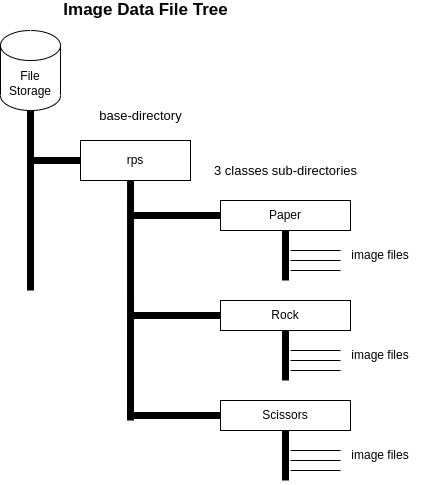

####**Let's examine the zip file and the extracted directory**

In [177]:
import os
dataset_dir = pathlib.Path(os.path.dirname(os.path.abspath(dataset_file)))
!ls $dataset_dir

hoh_test.zip  hoh.zip  horses  humans


####**list the subdirs**


In [178]:
from genericpath import isdir
subdir_names = [f for f in os.listdir(os.path.join(dataset_dir, ''))  if os.path.isdir(os.path.join(dataset_dir, f))]

print(subdir_names)

['humans', 'horses']


####**Download the test data**

The dataset's author composed another zip file which holds the `test` data. 

Next download it:

In [179]:
dataset_test_name = 'hoh_test'
dataset_test_url = 'https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip'
dataset_test_file = tf.keras.utils.get_file(origin=dataset_test_url, fname=dataset_test_name+'.zip', extract=True)

- The zip file downloaded now, holds the testing data. 

- The zip file was automatically extracted to the same locations as the test data.

- Normally, could extract the test files to a different location keeping the `test` split. 

- Reason for merging the splits was methodical - to demonstrate how to split the data to various slices.


- So now all data is stored together - no splits.


- We will split it to `train`, `validation` adn `test` dataset soon.



####**Show Total Downloaded Number of Files Per Class**

In [180]:
from os import listdir
from os.path import isfile, join
import os

class_dir_info = {}
file_ext = 'png'

base_data_dir = os.path.join(dataset_dir, '.')
for subdir_name in subdir_names:
  subdir = pathlib.Path(os.path.join(base_data_dir, subdir_name))
  files_count = len([file for file in os.listdir(subdir) if file.endswith(file_ext)])
  class_dir_info.update({'dir': subdir})
  print('{}: {} files'.format(subdir_name, files_count))

print('total file count: {}'.format(len(list(pathlib.Path(base_data_dir).glob('*/*.{}'.format(file_ext))))))

humans: 655 files
horses: 628 files
total file count: 1283


####***Visualization*** - take a brief look at randomly selected images from each class

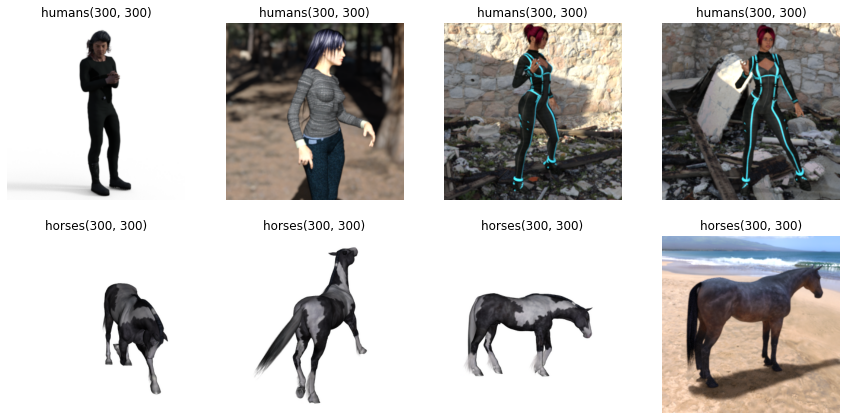

In [181]:
plt.figure(figsize=(15, 15))

for i, subdir_name in enumerate(subdir_names):
  path = pathlib.Path(os.path.join(base_data_dir, subdir_name))
  n_dir_images_show = 4
  for j in range(n_dir_images_show):
    ax = plt.subplot(4, 4, i*n_dir_images_show+j+1)
    filename =random.choice(os.listdir(path))
    img = PIL.Image.open(os.path.join(path, filename))
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(subdir_names[i]+str(img.size))

## 3. Create the Input Data Pipeline
---


####**Some Values Setup**


- **batch size**: A batch size of 32 is a good starting point. There's a trade-off here, were a too small batch size might lead to a too slow processing due to lacking vectorization. A too large batch might leads to low accuracy and thus longer training time.


In [182]:
batch_size = 32


- **image_height**, **image_width**: The are tradeoffs in setting the input dimenssions: keeping details vs process load. Anyway, since source data image is mostly none size uniform, resizing is essential. Since the NN deployed here has 5 pooling modules, which reduce size overall by 32, the size was set to a multiply of 32.

In [183]:
image_height = 224
image_width = 224

###**Create Train Dataset**


**Notes on some of the attributes of`image_dataset_from_directory` method**

- **directory**: is where the data is located. 

- **labels='inferred'** (default). In `inferred` mode, the labels are generated from the directory structure.

- **validation_split=0.2**: 20% of the dataset is assigned to validation, while the other 80% for training.

- **subset=training**: If `split` is used, this field value must be either `training` or `validation`.

- **batch_size**: Default 32

- **image_size**: Resizes the image size

- **image_size**: Resizes the image size


- **shuffle=True**: Shuffles file order. Needed for training dataset only.
- **seed**: Relates to shuffle randomness. If a specific seed is supplied, shuffle randomization will be regenerated.


- **color_mode**=rgb (default)


In [184]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  directory=base_data_dir, 
  labels="inferred", 
  validation_split=0.2,
  subset="training",
  image_size=(image_height, image_width),
  shuffle=True,
  seed=123,
  batch_size=batch_size)

Found 1283 files belonging to 2 classes.
Using 1027 files for training.


####Print Dataset's Class Names 

Since we use `Inferred` mode, the class names were extracted from the source files subdir names.




In [185]:
class_names = train_ds.class_names
print(class_names)


['horses', 'humans']


**Examine a single batches shapes:**

In [186]:
for image_batch, labels_batch in train_ds.take(1):
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [187]:
train_ds.element_spec

(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

####**Show some pictures by iterating on the batched dataset**

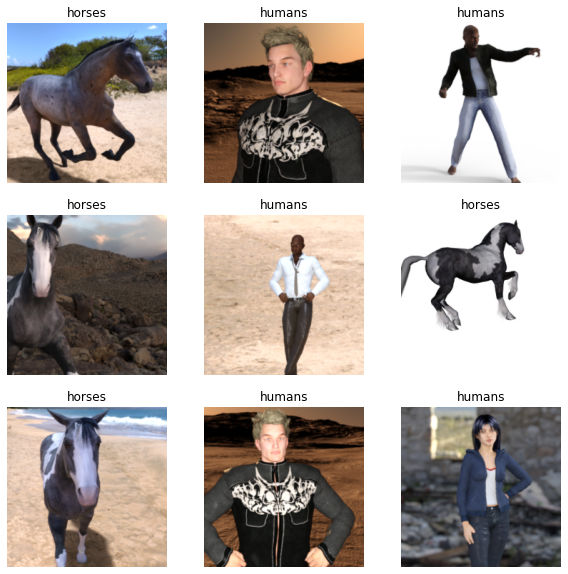

In [188]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

### **Create the validation dataset**

In [189]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  directory=base_data_dir, 
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(image_height, image_width),
  batch_size=batch_size)

Found 1283 files belonging to 2 classes.
Using 256 files for validation.


## 4. Configure Dataset for Performance
---


####**Configure the Dataset for Performance**

Some essential data transformations were already performed by `image_dataset_from_directory`. 

That includes **`batching`**, **`image format decoding`**, **`splitting`** and `resizing`.

Those transformation were essential for the execution of the network.


Next transormations are needed to improve performance:


- **cache** -  keeps the images in memory after they're loaded off disk during 
the first epoch.

- **shuffle** - fills a buffer with buffer_size elements, then randomly samples elements from this buffer. The sampled elements are replaced by new dataset elements as depicted in the diagram below. 

- **prefetch** -  overlaps data preprocessing and model execution while training. (The tf.data.AUTOTUNE parameter defines a dynamic tuning of the number of prefetched data elements. The number depends on the number of batches consumed in a single step, i.e. on parallelism extent). In case both **perfecth** and **shuffle** are set, the shuffle buffer should be greater than or equal to the full size of the dataset.

- **normalization** - standardizes the inputs to the range [0,1], which improves performance.


- **augmentation** - expands training dataset, increases the diversity of training set, by applying transformations, such as image rotation, flips, shifts, and shear.




In [190]:
train_ds = train_ds.cache().shuffle(buffer_size=1000, seed=None, reshuffle_each_iteration=None, name=None).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

####**Data Augmentation** - Expand training dataset size

(Find details on Data Augmentation in a related post (TBD))

In [191]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(image_height,
                                  image_width,
                                  3)),
    layers.RandomRotation(0.1, fill_mode="nearest",),
    layers.RandomZoom(0.1),
  ]
)

#####**Demonstrate Augmentation Visualization**: 

Here's how the augmented images look like

- Original image is at upper left

- 8 randomly augmented images. 


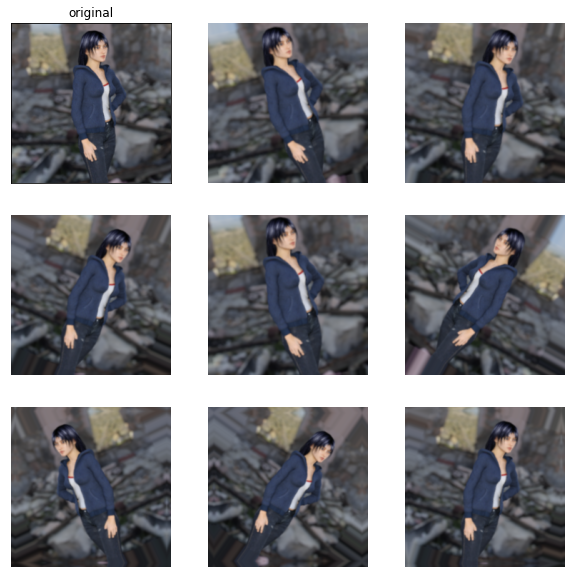

In [192]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  image = images[random.randint(0, len(images)-1)]
  ax = plt.subplot(3, 3, 1)
  ax.set_title('original')
  plt.imshow(image/255)
  ax.set_xticks([])
  ax.set_yticks([])

  for i in range(8):
    augmented_images = data_augmentation((tf.expand_dims(image, axis=0, name=None)))
    ax = plt.subplot(3, 3, i + 2)
    plt.imshow(augmented_images[0].numpy().astype("float32")/255)
    plt.axis("off")

#####**Set Augmentation to training dataset**

In [193]:
train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

####**Normalize the data**

Standardizes the inputs. This is often integrated within the model, but can also be set on the dataset like so:

In [ ]:
normalization_layer = layers.Rescaling(1./255)

In [ ]:
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

####**Present Train Dataset**

A bunch of images

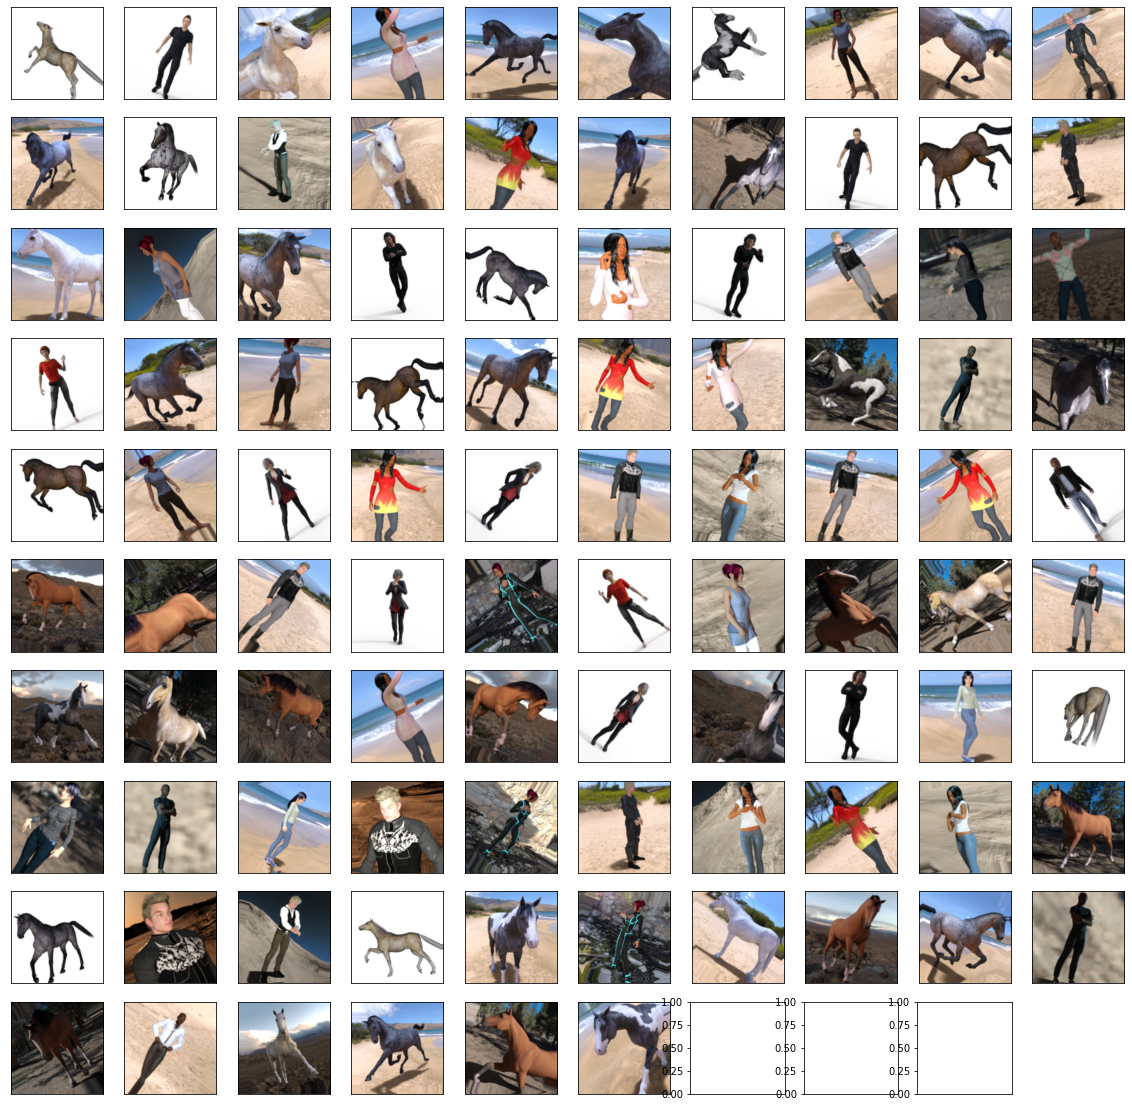

In [ ]:
batches_in_loop = np.minimum(3, len(train_ds))

fig, axes = plt.subplots(nrows=10, ncols=10, sharex=True)
fig.set_figheight(20)
fig.set_figwidth(20)

for j in range(batches_in_loop):
  image_batch, _ = next(iter(train_ds))
  for i in range(len(image_batch)):
    axf = axes.flat[j*len(image_batch)+i]
    axf.imshow(image_batch[i])
    plt.axis("off")
    axf.set_xticks([])
    axf.set_yticks([])

####**Split a Test Validation Slice from the Validation Dataset**

The validation dataset is split to produce a test dataset slice

In [ ]:
test_ds = val_ds.take(len(val_ds) // 5)
val_ds = val_ds.skip(len(val_ds) // 5)

## 5. Set the model
---


The model consists of 7 layers:
- It begins with 5 convolution blocks, each followed by a max pooling module.

- Then, after flattening the data, convolution blocks are followed by 2 dense layers: 
 - A 512 units dense layer
 - The output layer, with 1 unit and a sigmoid activation, for the binary decision.


In [ ]:
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(64, 3, activation='relu', padding='SAME'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu', padding='SAME'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(128, 3, activation='relu', padding='SAME'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(128, 3, activation='relu', padding='SAME'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(128, 3, activation='relu', padding='SAME'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(1, activation = 'sigmoid')
])

<a name='5'></a>
## 6. Compile the Model
---


- optimizer `adam` - a commonly used stochastic adaptive optimizer.  
- loss function `SparseCategoricalCrossentropy` - commonly used for image classification with more than 2 classes
- from_logits=True - This indicate the loss function that that the output is not normalized, i.e. there is no softmax function at the output. BTW, excluding the softmax function from the model, is considered more numerically stable. The softamx is then added by the loss function module.


In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

## 7. Train the model
---


**Set an Early Stopping Callback:**

- Stop training when a monitored metric has stopped improving.

- Wait before stopping according `patience` value.

- Restore best waits, after stopping



In [ ]:
early_stop_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                min_delta=0, 
                                patience=10, 
                                verbose=1, 
                                mode='auto', 
                                baseline=None, 
                                restore_best_weights=True)

Now do the fit - 30 epochs, with early_stop_cb.

In [ ]:
epochs=30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stop_cb],
)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


33/33 [==============================] - 12s 353ms/step - loss: 0.5336 - accuracy: 0.6913 - val_loss: 0.2713 - val_accuracy: 0.9152
Epoch 2/30
33/33 [==============================] - 11s 337ms/step - loss: 0.3681 - accuracy: 0.8705 - val_loss: 0.2470 - val_accuracy: 0.8884
Epoch 3/30
33/33 [==============================] - 11s 336ms/step - loss: 0.3359 - accuracy: 0.8617 - val_loss: 0.2076 - val_accuracy: 0.9464
Epoch 4/30
33/33 [==============================] - 11s 334ms/step - loss: 0.2437 - accuracy: 0.8968 - val_loss: 0.1499 - val_accuracy: 0.9196
Epoch 5/30
33/33 [==============================] - 11s 336ms/step - loss: 0.1659 - accuracy: 0.9377 - val_loss: 0.0757 - val_accuracy: 0.9732
Epoch 6/30
33/33 [==============================] - 11s 337ms/step - loss: 0.1534 - accuracy: 0.9464 - val_loss: 0.0741 - val_accuracy: 0.9732
Epoch 7/30
33/33 [==============================] - 11s 334ms/step - loss: 0.1211 - accuracy: 0.9552 - val_loss: 0.0415 - val_accuracy: 0.9911
Epoch 8/30

## 8. Display model summary
---


In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 56, 56, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 28, 28, 128)     

## 9 Visualize training results
---


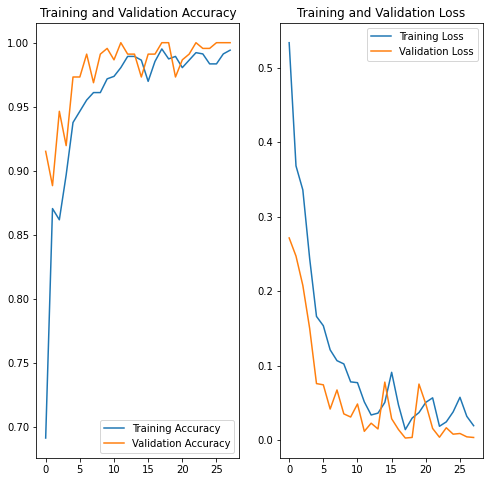

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = history.epoch

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 10. Inference
---

**The network is now trained, and ready to be tested in `Inference` mode.**

Below are 2 subsections:

- Execute `model.predict` on Test Dataset, examine results


- Exceute `model.evaluate` and findcaluclated `loss` and `accuracy`.


#####**Execute `Predict` on Test Dataset**

**Note**: Since activation in output layer is a sigmoid, decsion threshold is 0.5 

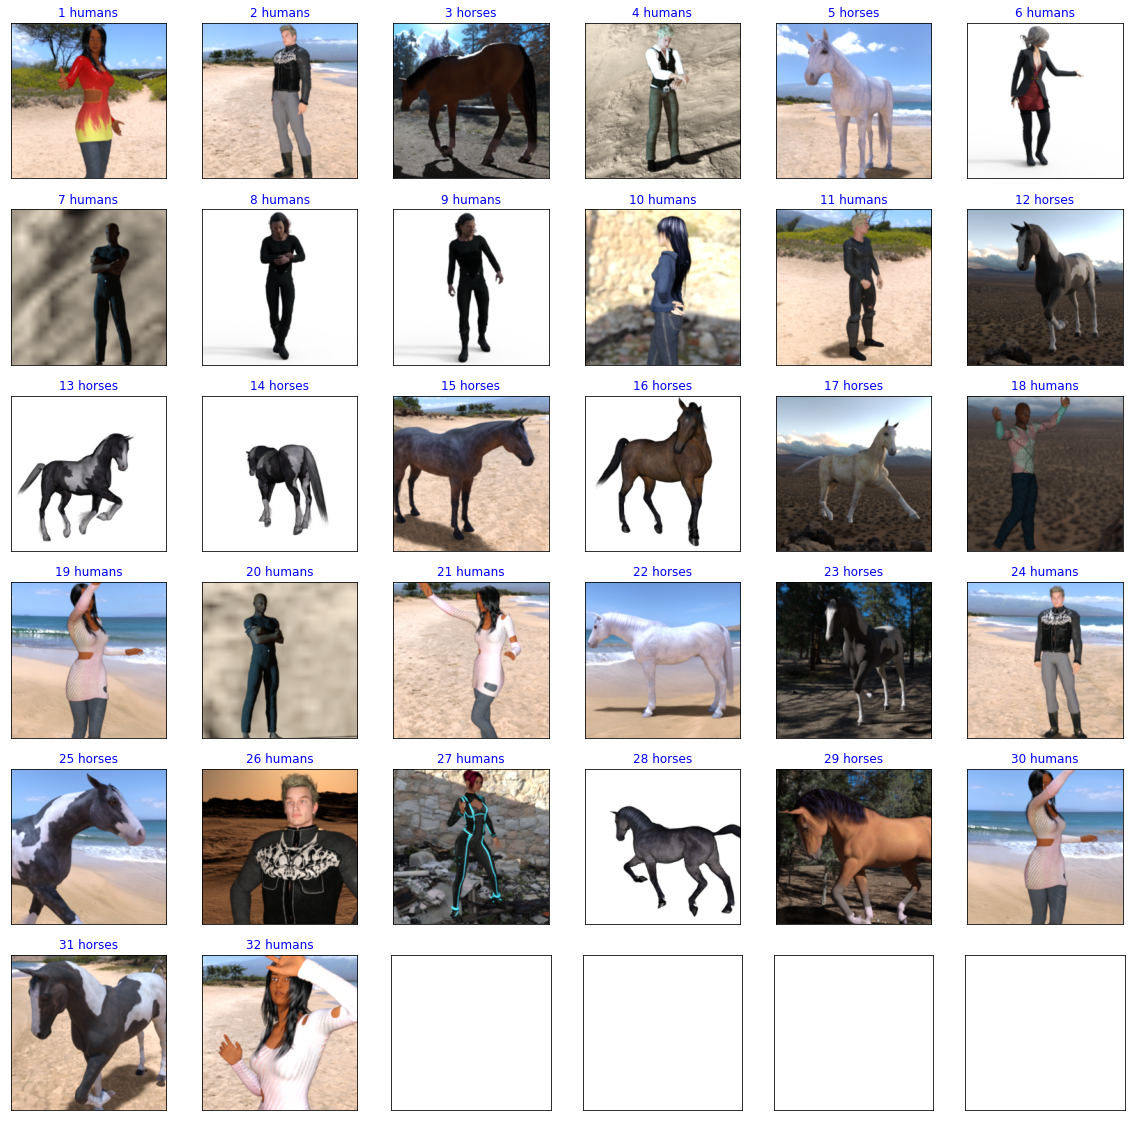

In [ ]:
image_batch, labels_batch = next(iter(test_ds))
results = model.predict(image_batch)

predictions = tf.where(results < 0.5, 0, 1)

fig, axes = plt.subplots(nrows=6, ncols=6, sharex=True)
fig.set_figheight(20)
fig.set_figwidth(20)

plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);

for  idx, (image, label, prediction) in enumerate(zip(image_batch, labels_batch, predictions)):
  axes.flat[idx].imshow(image)
  axes.flat[idx].set_xticks([])
  axes.flat[idx].set_yticks([])
  error = False if next(iter(prediction)) == label else True
  color = 'red' if error else 'blue'
  axes.flat[idx].set_title("{} {}".format(idx + 1, 
                                          class_names[next(iter(prediction)) ]), 
                           color=color
  )   


#####**Run `model.predict` on Test Dataset**

Find Loss and Accuracy


In [ ]:
results = model.evaluate(test_ds)
print(f'Test {model.metrics_names[0]}: {results[0]}: Test {model.metrics_names[1]}: {results[1]}')

1/1 [==============================] - 0s 56ms/step - loss: 6.3491e-05 - accuracy: 1.0000
Test loss: 6.349060276988894e-05: Test accuracy: 1.0
